In [51]:
import os
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import glob

In [52]:
local_path = "animals"
data = {"imgpath": [], "labels": []}

In [56]:
with open("name.txt", "r") as file:
    animal_categories = [line.strip() for line in file.readlines()]

In [57]:
for folder in os.listdir(local_path):
    folderpath = os.path.join(local_path, folder)
    if os.path.isdir(folderpath):
        if folder in animal_categories:  # Check if the folder name is in the list of categories
            filelist = glob.glob(os.path.join(folderpath, "*.jpg"))  # Assuming JPG images
            data["imgpath"].extend(filelist)
            data["labels"].extend([folder] * len(filelist))

In [58]:
df = pd.DataFrame(data)

In [59]:
# Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])

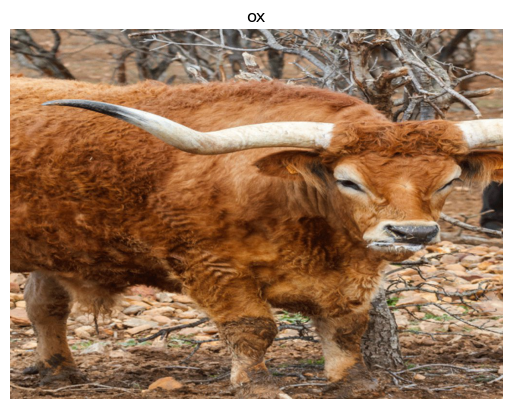

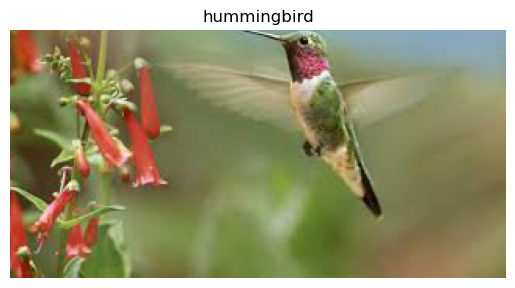

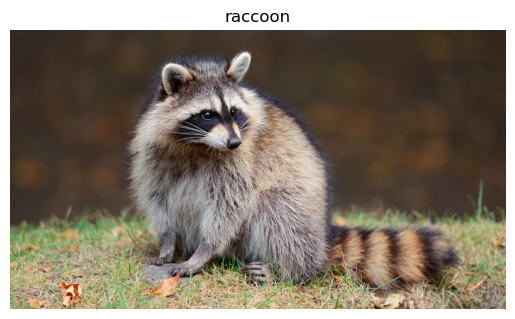

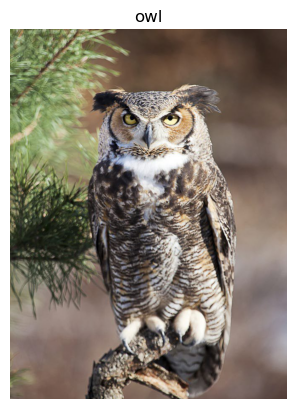

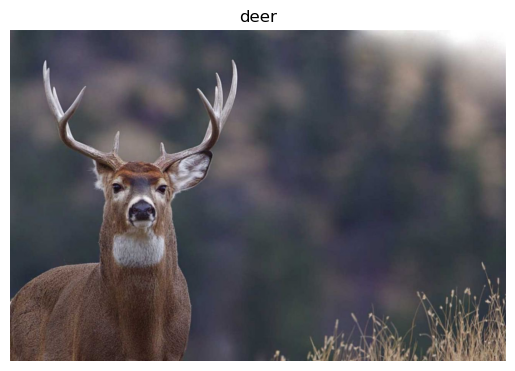

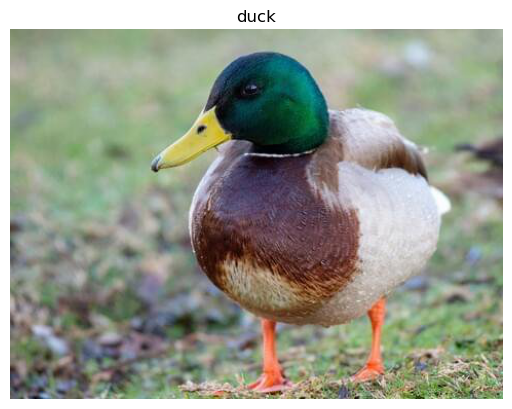

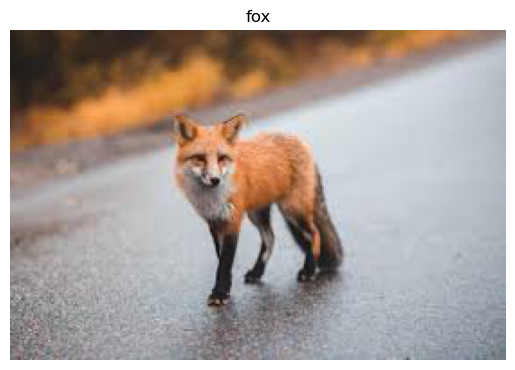

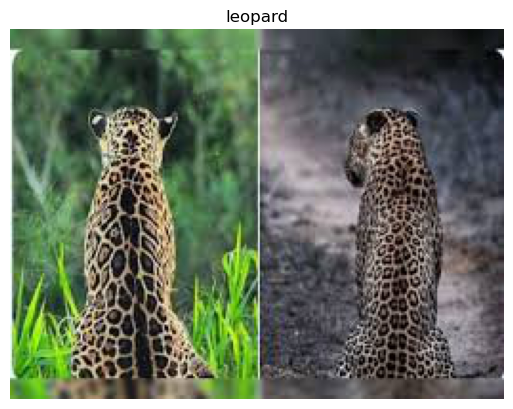

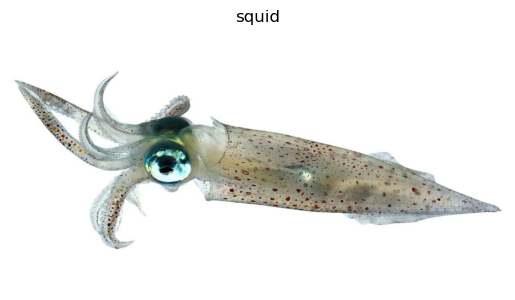

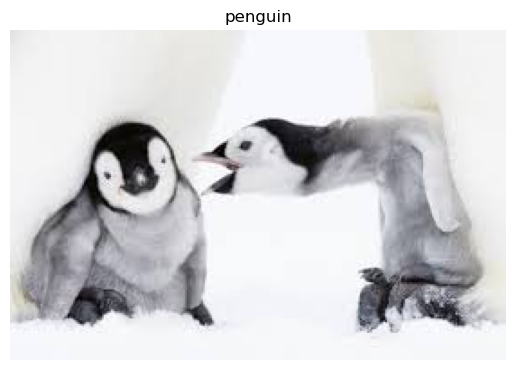

In [62]:
# Display a few images with labels

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
sample_df = df.sample(n=10)  

for index, row in sample_df.iterrows():
    img = mpimg.imread(row['imgpath'])
    plt.imshow(img)
    plt.title(row['labels'])
    plt.axis('off')
    plt.show()

In [63]:
from sklearn.model_selection import train_test_split

# Splitting the initial dataset into train, validation, and test sets
train_df, remaining_df = train_test_split(df, train_size=0.70, shuffle=True, random_state=124)
valid_df, test_df = train_test_split(remaining_df, train_size=0.70, shuffle=True, random_state=124)

# Resetting the indices of the dataframes
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [64]:
print("Train DataFrame:")
print(train_df.head())

print("\nValidation DataFrame:")
print(valid_df.head())

print("\nTest DataFrame:")
print(test_df.head())

Train DataFrame:
                            imgpath     labels  encoded_labels
0   animals\flamingo\8ad31621cf.jpg   flamingo              25
1   animals\elephant\55ec112288.jpg   elephant              24
2  animals\jellyfish\2a91fc6ffe.jpg  jellyfish              41
3      animals\goose\06bc2c2f26.jpg      goose              30
4   animals\mosquito\9adc6ec866.jpg   mosquito              49

Validation DataFrame:
                           imgpath    labels  encoded_labels
0      animals\deer\4d8f0a4d6f.jpg      deer              17
1  animals\mosquito\2dd69c8706.jpg  mosquito              49
2     animals\squid\825d61c8b7.jpg     squid              78
3       animals\rat\25da4ae00a.jpg       rat              68
4     animals\whale\8e29f98a3b.jpg     whale              85

Test DataFrame:
                          imgpath   labels  encoded_labels
0    animals\shark\69ddff92d4.jpg    shark              74
1    animals\snake\51e556629f.jpg    snake              76
2  animals\dolphin\9ff

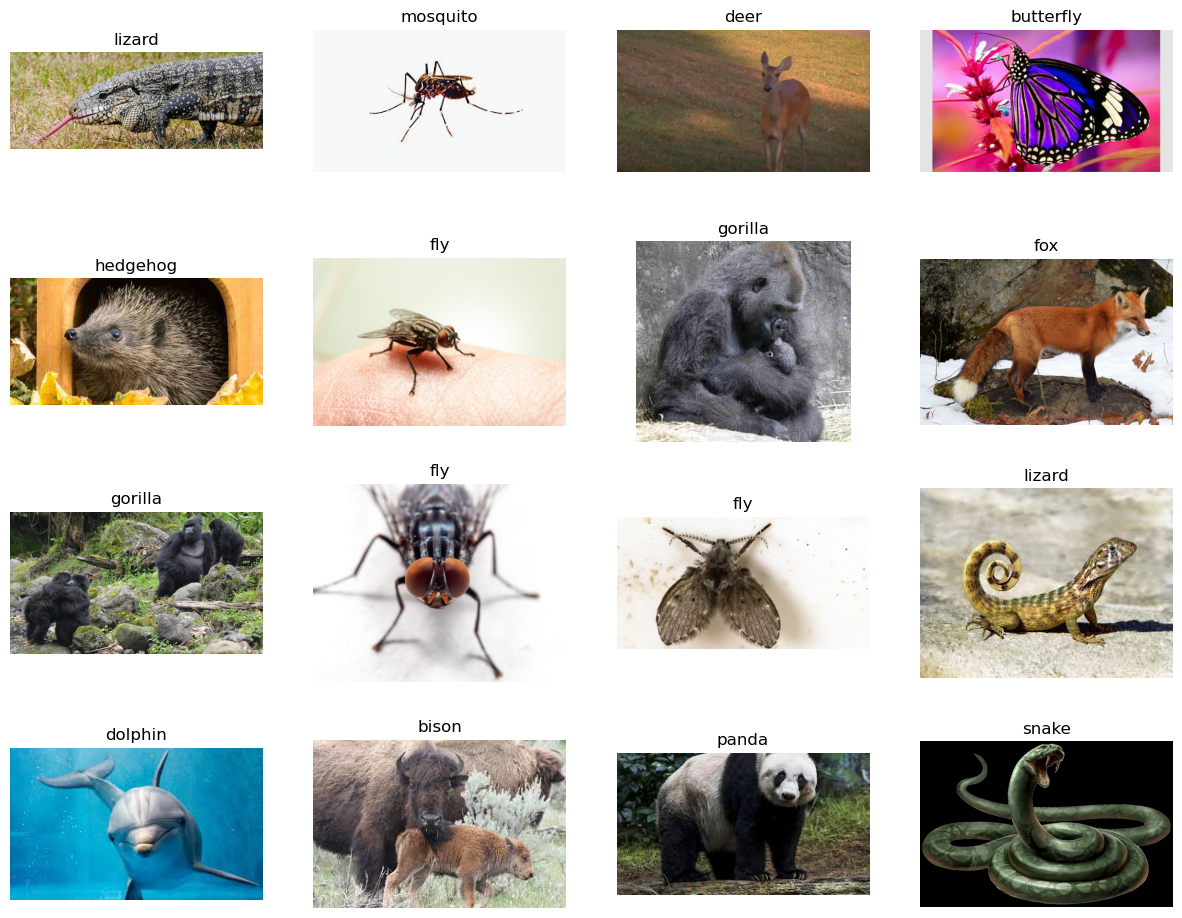

In [65]:
plt.figure(figsize=(15,12))
for i, row in test_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

In [66]:
BATCH_SIZE = 15
IMAGE_SIZE = (224, 224)

In [70]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=20,           
    width_shift_range=0.2,          
    height_shift_range=0.2,        
    shear_range=0.2,               
    zoom_range=0.2,
    horizontal_flip=True,          
    vertical_flip=False,            
    fill_mode='nearest'            
)

In [71]:
# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

Found 11340 validated image filenames belonging to 90 classes.


In [72]:
val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 3402 validated image filenames belonging to 90 classes.


In [73]:
test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 1458 validated image filenames belonging to 90 classes.


In [74]:
# Load the pretained model
pretrained_model = tf.keras.applications.EfficientNetB3(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

43941136/43941136 [==============================] - 6s 0us/step


In [75]:
# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False


In [76]:
num_classes = len(set(train_images.classes))

In [78]:
# Data Augmentation Step
from tensorflow.keras import layers
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.15),
  layers.experimental.preprocessing.RandomZoom(0.15),
  layers.experimental.preprocessing.RandomContrast(0.15),
], name='AugmentationLayer')

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

from tensorflow.keras.models import Model
inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = augment(inputs)
pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x) 
x = BatchNormalization()(x)
x = layers.Dropout(0.45)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)

In [83]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [84]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 dense_3 (Dense)             (None, 256)               393472    
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024  

In [86]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [87]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True), # if val loss decreases for 10 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)
model.save_weights('./checkpoints/my_checkpoint')

Epoch 1/10
756/756 [==============================] - 1017s 1s/step - loss: 1.8190 - accuracy: 0.5951 - val_loss: 0.4947 - val_accuracy: 0.8730 - lr: 5.0000e-04
Epoch 2/10
756/756 [==============================] - 969s 1s/step - loss: 0.8671 - accuracy: 0.7823 - val_loss: 0.3277 - val_accuracy: 0.9071 - lr: 5.0000e-04
Epoch 3/10
756/756 [==============================] - 1068s 1s/step - loss: 0.6837 - accuracy: 0.8240 - val_loss: 0.2764 - val_accuracy: 0.9236 - lr: 5.0000e-04
Epoch 4/10
756/756 [==============================] - 1086s 1s/step - loss: 0.6184 - accuracy: 0.8457 - val_loss: 0.2640 - val_accuracy: 0.9250 - lr: 5.0000e-04
Epoch 5/10
756/756 [==============================] - 955s 1s/step - loss: 0.5782 - accuracy: 0.8459 - val_loss: 0.2463 - val_accuracy: 0.9318 - lr: 5.0000e-04
Epoch 6/10
756/756 [==============================] - 938s 1s/step - loss: 0.5605 - accuracy: 0.8497 - val_loss: 0.2439 - val_accuracy: 0.9347 - lr: 5.0000e-04
Epoch 7/10
756/756 [=================

In [96]:
# Extract training history
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']


In [97]:
import numpy as np
# Find the best epoch based on validation loss and accuracy
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
best_epoch_loss = index_loss + 1
best_epoch_acc = index_acc + 1


In [98]:
# Create a list of epochs
epochs = range(1, len(tr_acc) + 1)


In [99]:
# Plot training history
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

<Figure size 2000x800 with 0 Axes>

In [102]:
# Plot training history
plt.figure(figsize=(50, 20))
plt.style.use('fivethirtyeight')

<Figure size 5000x2000 with 0 Axes>

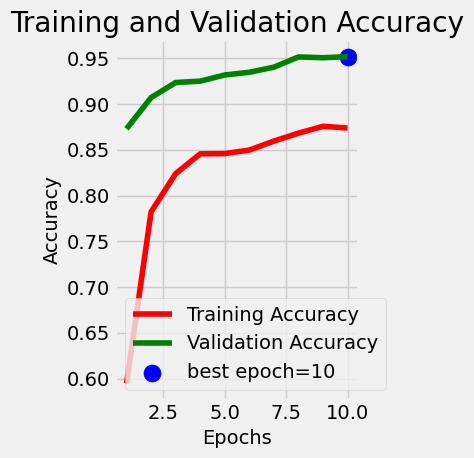

In [103]:
# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(best_epoch_acc, acc_highest, s=150, c='blue', label=f'best epoch={best_epoch_acc}')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [104]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.16639
Test Accuracy: 94.79%


In [107]:
from sklearn.metrics import classification_report, f1_score , confusion_matrix

y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

98/98 [==============================] - 115s 1s/step
F1 Score: 0.9596536726245322
                precision    recall  f1-score   support

      antelope       0.89      0.94      0.92        18
        badger       1.00      1.00      1.00        12
           bat       1.00      0.94      0.97        18
          bear       1.00      1.00      1.00         8
           bee       1.00      1.00      1.00         9
        beetle       1.00      0.94      0.97        18
         bison       0.93      1.00      0.96        13
          boar       1.00      1.00      1.00        16
     butterfly       1.00      1.00      1.00        16
           cat       1.00      0.93      0.96        14
   caterpillar       1.00      1.00      1.00        22
    chimpanzee       0.92      1.00      0.96        12
     cockroach       1.00      1.00      1.00        18
           cow       1.00      1.00      1.00        13
        coyote       0.96      0.96      0.96        23
          crab      

In [108]:
classes = {v: k for k, v in test_images.class_indices.items()}

# Create the Predictions DataFrame
Predictions = pd.DataFrame({
    "Image Index": range(len(test_images.labels)),
    "Test Labels": test_images.labels,
    "Test Classes": [classes[i] for i in test_images.labels],
    "Prediction Labels": y_pred,
    "Prediction Classes": [classes[i] for i in y_pred],
    "Path": test_images.filenames,
    "Prediction Probability": [x for x in model.predict(test_images).max(axis=1)]
})

# Display the first 8 rows
Predictions.head(8)

98/98 [==============================] - 107s 1s/step


Image Index  Test Labels Test Classes  Prediction Labels  \
0            0           74        shark                 74   
1            1           76        snake                 76   
2            2           19      dolphin                 19   
3            3           73         seal                 73   
4            4           85        whale                 85   
5            5           14       coyote                 86   
6            6           55        otter                 55   
7            7           29     goldfish                 29   

  Prediction Classes                             Path  Prediction Probability  
0              shark     animals\shark\69ddff92d4.jpg                0.999925  
1              snake     animals\snake\51e556629f.jpg                0.965676  
2            dolphin   animals\dolphin\9ffb640dea.jpg                0.999882  
3               seal      animals\seal\7dcdedd38f.jpg                0.935668  
4              whale     animals\whale\23a40bb03d.jpg                0.997658  
5               wolf    animals\coyote\36f0afcd07.jpg                0.593169  
6              otter     animals\otter\631df1efd9.jpg                0.972629  
7           goldfish  animals\goldfish\0b1c90f603.jpg                0.999921

98/98 [==============================] - 92s 936ms/step


Image Index  Test Labels Test Classes  Prediction Labels  \
0            0           74        shark                 74   
1            1           76        snake                 76   
2            2           19      dolphin                 19   
3            3           73         seal                 73   
4            4           85        whale                 85   
5            5           14       coyote                 86   
6            6           55        otter                 55   
7            7           29     goldfish                 29   

  Prediction Classes                             Path  Prediction Probability  
0              shark     animals\shark\69ddff92d4.jpg                0.999895  
1              snake     animals\snake\51e556629f.jpg                0.866336  
2            dolphin   animals\dolphin\9ffb640dea.jpg                0.998552  
3               seal      animals\seal\7dcdedd38f.jpg                0.870521  
4              whale     animals\whale\23a40bb03d.jpg                0.998210  
5               wolf    animals\coyote\36f0afcd07.jpg                0.984394  
6              otter     animals\otter\631df1efd9.jpg                0.966921  
7           goldfish  animals\goldfish\0b1c90f603.jpg                0.999957

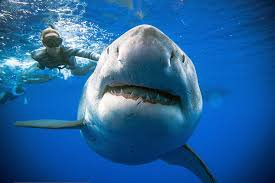

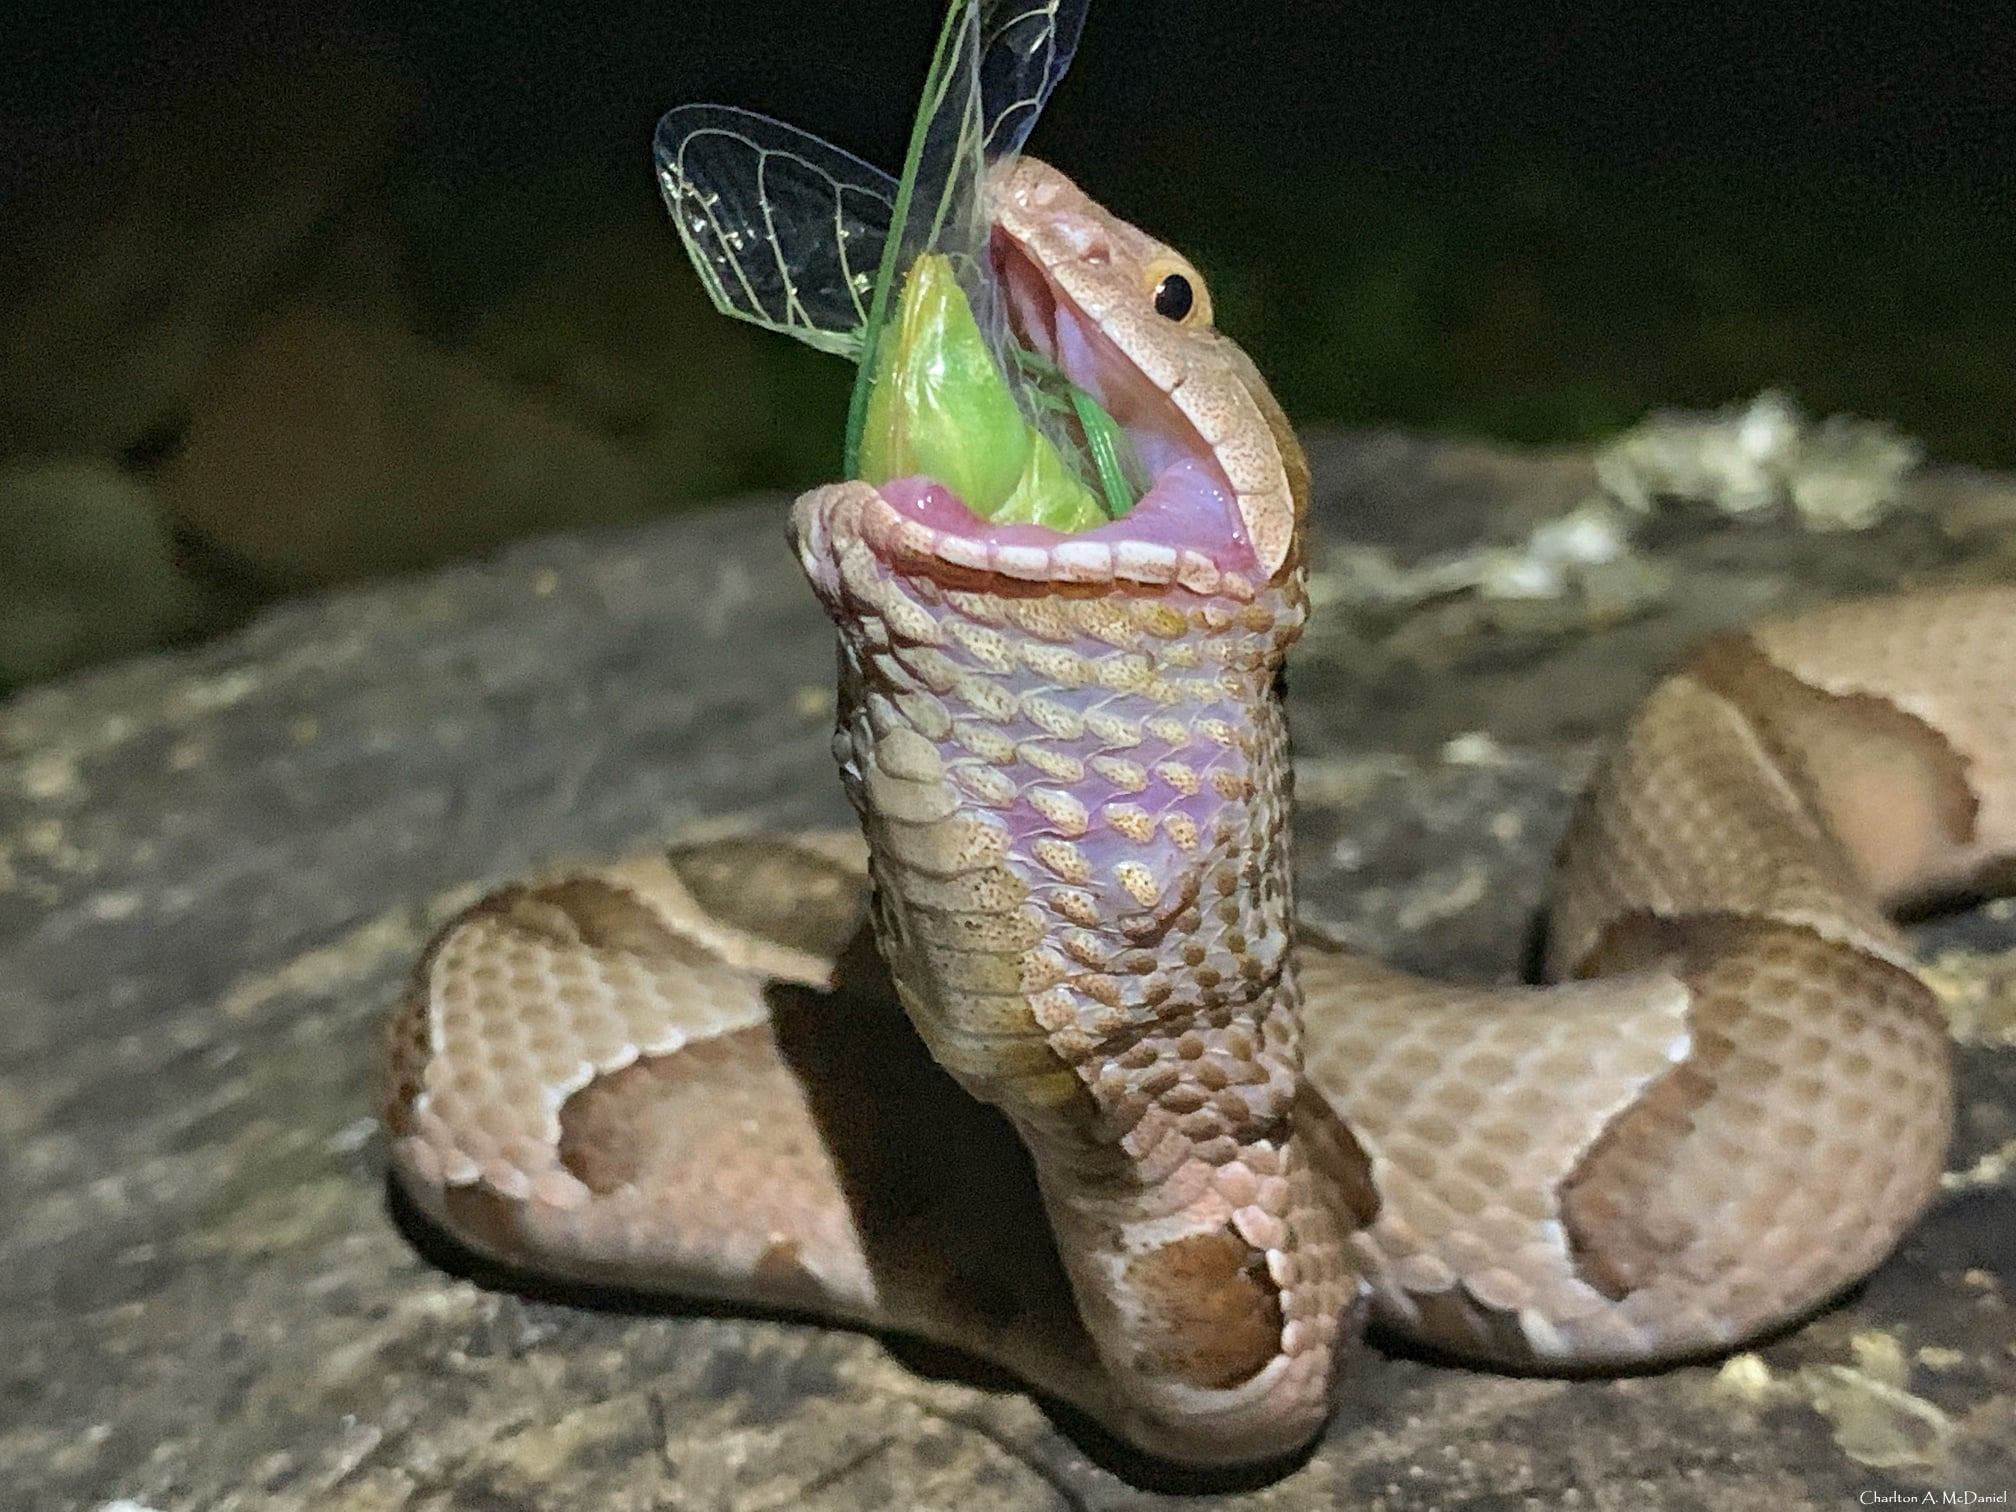

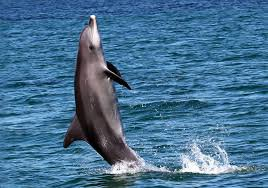

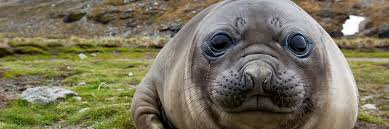

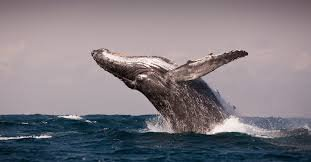

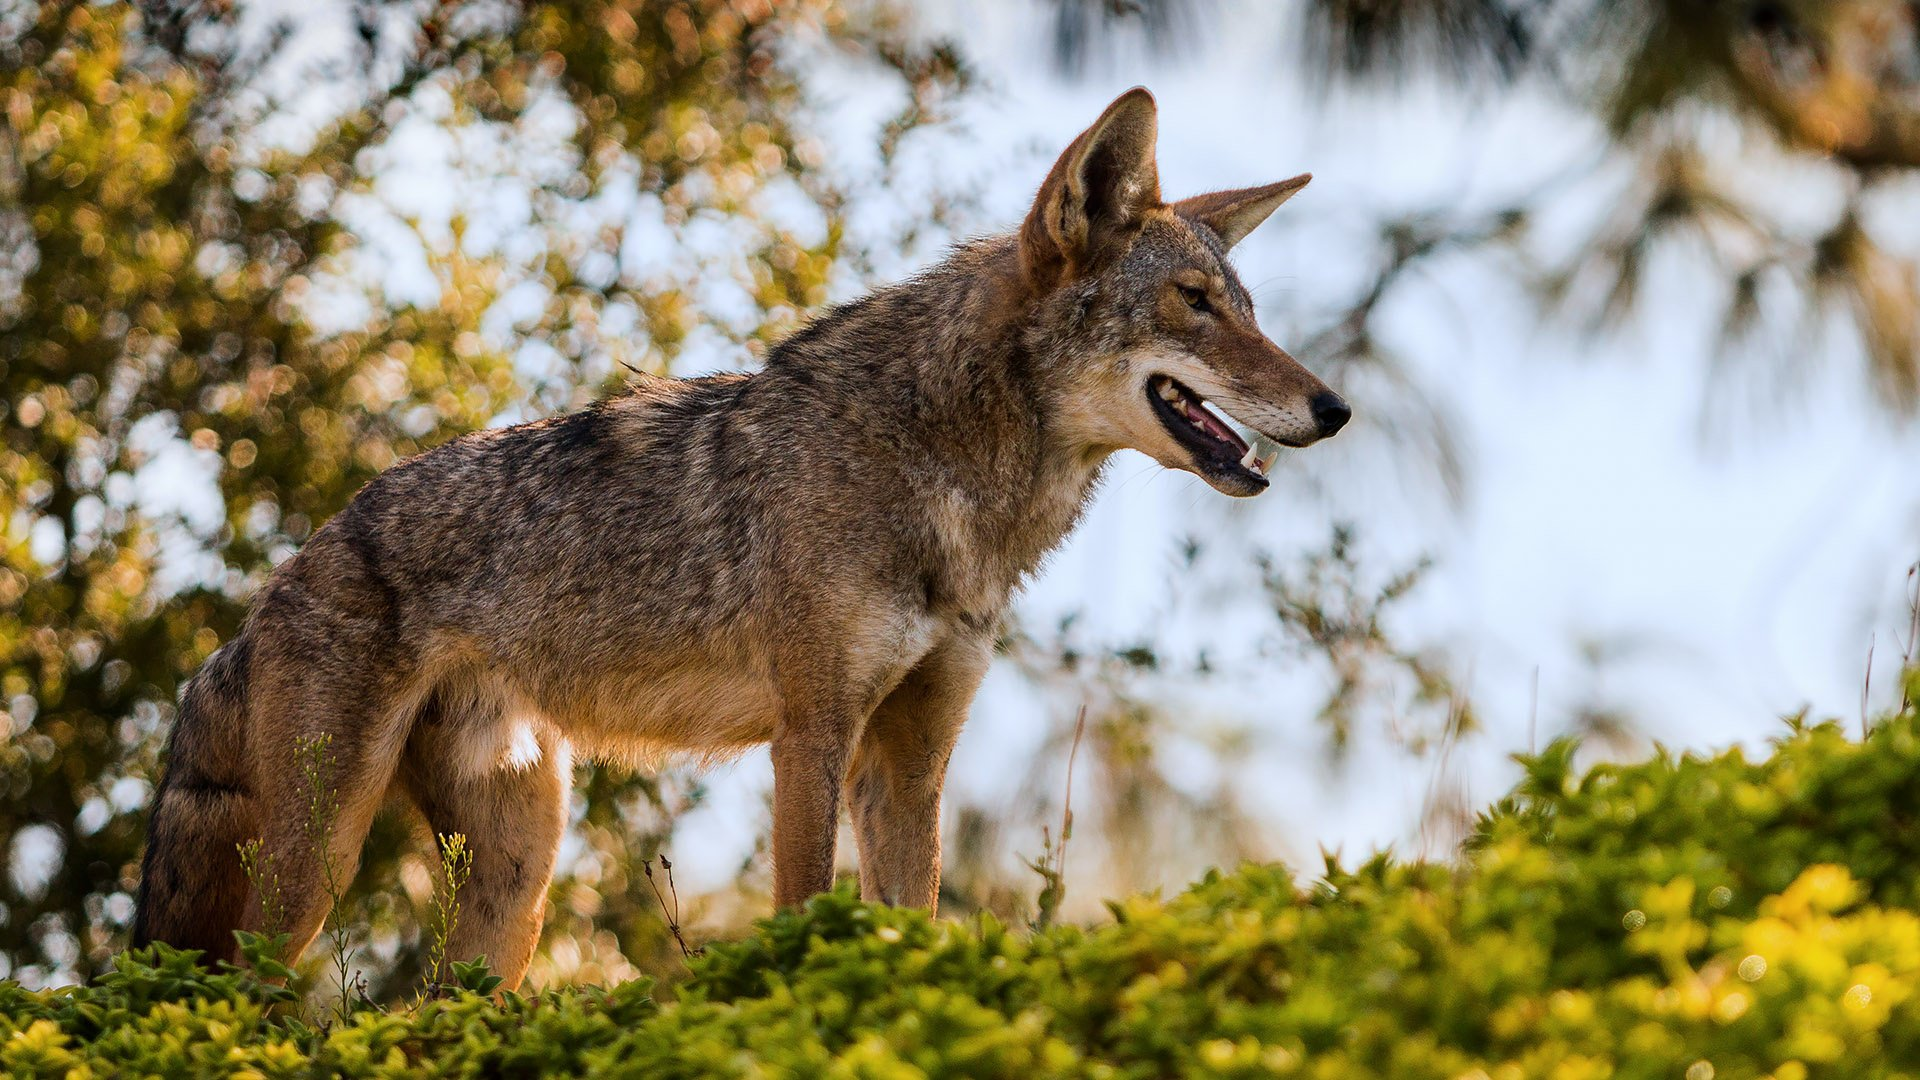

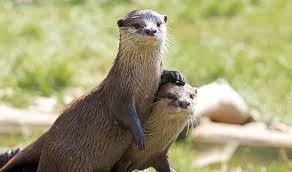

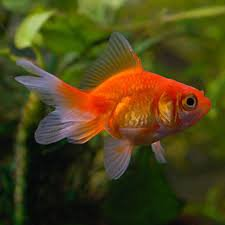

In [120]:
import pandas as pd
from IPython.display import Image, display

# Create a dictionary to map class indices to class names
classes = {v: k for k, v in test_images.class_indices.items()}

# Create the Predictions DataFrame
Predictions = pd.DataFrame({
    "Image Index": range(len(test_images.labels)),
    "Test Labels": test_images.labels,
    "Test Classes": [classes[i] for i in test_images.labels],
    "Prediction Labels": y_pred,
    "Prediction Classes": [classes[i] for i in y_pred],
    "Path": test_images.filenames,
    "Prediction Probability": [x for x in model.predict(test_images).max(axis=1)]
})

# Display the first 8 rows
display(Predictions.head(8))

# Display images for the first 8 rows
for _, row in Predictions.head(8).iterrows():
    display(Image(filename=row['Path']))